# Data Analysis and Visualizations
---

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
plt.style.use('fivethirtyeight')

# connect to database 
db_conn = sqlite3.connect('../../data/sql_db/spotify_data.db')

# create a function to run queries and output pandas dataframe
def Q(query, db=db_conn):
    '''takes in SQL query and returns a pandas dataframe'''
    return pd.read_sql(query, db)

## Check to see if all of our tables loaded.

In [2]:
Q('''
SELECT name
FROM sqlite_master
WHERE type = 'table';
  ''')

,name
0,Artist
1,Album
2,Track
3,Track_Feature


### As we can see from the output above all 4 tables loaded correctly.

## Create views
---

## Top 10 songs by artist in terms of duration_ms:

In [3]:
# This will drop the view if it exists. Need this in order to rerun code.
db_conn.execute('''DROP VIEW IF EXISTS top_10_songs_ms_view;''')

In [4]:
db_conn.execute('''
CREATE VIEW top_10_songs_ms_view AS
WITH top_songs_by_artist_cte AS 
-- subquery for cte, want necessary columns and additional column that ranks songs by duration grouped by artist
(SELECT ar.artist_name, t.song_name, a.album_name, t.duration_ms,
    DENSE_RANK() OVER (PARTITION BY ar.artist_name ORDER BY t.duration_ms DESC) as song_duration_rank_by_artist
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
LEFT JOIN Track t 
    ON a.album_id = t.album_id
ORDER BY t.duration_ms DESC)
-- query the cte for top 5 longest songs by artist
SELECT *
FROM top_songs_by_artist_cte
-- only want songs ranked in the top 10
WHERE song_duration_rank_by_artist BETWEEN 1 AND 10
ORDER BY artist_name ASC, song_duration_rank_by_artist ASC;
''')

In [5]:
Q('''
SELECT *
FROM top_10_songs_ms_view;
''')

,artist_name,song_name,album_name,duration_ms,song_duration_rank_by_artist
0,Baby Keem,range brothers (with Kendrick Lamar),The Melodic Blue,316733,1
1,Baby Keem,trademark usa,The Melodic Blue,270670,2
2,Baby Keem,lost souls,The Melodic Blue,269727,3
3,Baby Keem,lost souls (with Brent Faiyaz),The Melodic Blue,269727,3
4,Baby Keem,scars,The Melodic Blue,266010,4
...,...,...,...,...,...
228,Travis Scott,STOP TRYING TO BE GOD,ASTROWORLD,338438,6
229,Travis Scott,Nightcrawler (feat. Swae Lee & Chief Keef),Rodeo (Expanded Edition),321560,7
230,Travis Scott,first take,Birds In The Trap Sing McKnight,313909,8
231,Travis Scott,SICKO MODE,ASTROWORLD,312820,9


### As we can see from the output above our view creation was a success. Now to create the 2nd view.

## Top 20 artists in the database by # of followers:

In [6]:
db_conn.execute('''DROP VIEW IF EXISTS top_20_artist_num_followers_view;''')

In [7]:
db_conn.execute('''
CREATE VIEW top_20_artist_num_followers_view AS
SELECT artist_name, genre, followers, popularity
FROM Artist
ORDER BY followers DESC
LIMIT 20;
''')

In [8]:
Q('''
SELECT *
FROM top_20_artist_num_followers_view;
''')

,artist_name,genre,followers,popularity
0,Drake,canadian hip hop,67117766,95
1,The Weeknd,canadian contemporary r&b,49839489,94
2,Post Malone,dfw rap,38187668,89
3,Juice WRLD,chicago rap,25709252,89
4,Michael Jackson,pop,24181535,82
5,Travis Scott,hip hop,21044423,87
6,Kanye West,chicago rap,18252307,91
7,J. Cole,conscious hip hop,17913573,85
8,Lil Uzi Vert,melodic rap,13786405,85
9,Future,atl hip hop,12152231,88


### As we can see from the output above we successfully created a view with the top 10 artist by number of followers. Now to create the 3rd view.

## Top 10 songs by artist in terms of tempo:

In [9]:
db_conn.execute('''DROP VIEW IF EXISTS top_10_songs_tempo_view;''')

In [10]:
db_conn.execute('''
CREATE VIEW top_10_songs_tempo_view AS
WITH top_tempo_cte AS
-- subquery for cte, need to rank songs by tempo
(SELECT ar.artist_name, t.song_name, tf.tempo,
    DENSE_RANK() OVER (PARTITION BY ar.artist_name ORDER BY tf.tempo DESC) as tempo_rank_by_artist
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
LEFT JOIN Track t 
    ON a.album_id = t.album_id
LEFT JOIN Track_Feature tf
    ON t.track_id = tf.track_id)
-- query the cte for top 5 tracks with highest tempo
SELECT *
FROM top_tempo_cte
WHERE tempo_rank_by_artist BETWEEN 1 AND 10
ORDER BY artist_name ASC, tempo_rank_by_artist ASC;
''')

In [11]:
Q('''
SELECT *
FROM top_10_songs_tempo_view;
''')

,artist_name,song_name,tempo,tempo_rank_by_artist
0,Baby Keem,no sense,180.013,1
1,Baby Keem,Xmen,170.030,2
2,Baby Keem,lost souls,170.022,3
3,Baby Keem,lost souls (with Brent Faiyaz),169.994,4
4,Baby Keem,Miss Charlotte,161.989,5
...,...,...,...,...
210,Travis Scott,SICKO MODE,155.008,6
211,Travis Scott,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,153.131,7
212,Travis Scott,ASTROTHUNDER,151.901,8
213,Travis Scott,Saint,150.058,9


### The view creation was a success, now let's work on our 4th view.

## Top 10 Artists with most explicit tracks:

In [12]:
db_conn.execute('''DROP VIEW IF EXISTS top_10_explicit_artist_view;''')

In [13]:
db_conn.execute('''
CREATE VIEW top_10_explicit_artist_view AS
SELECT ar.artist_name, SUM(t.explicit) as num_explicit_tracks
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
LEFT JOIN Track t 
    ON a.album_id = t.album_id
GROUP BY ar.artist_name
ORDER BY num_explicit_tracks DESC
LIMIT 10;
''')

In [14]:
Q('''
SELECT *
FROM top_10_explicit_artist_view;
''')

,artist_name,num_explicit_tracks
0,Lil Uzi Vert,145
1,Gunna,134
2,Lil Baby,124
3,Juice WRLD,119
4,NAV,97
5,J. Cole,96
6,Drake,95
7,Post Malone,86
8,Travis Scott,66
9,Playboi Carti,58


### View creation was a success, now let's create our 5th view.

## Top 5 genres with highest average energy:

In [15]:
db_conn.execute('''DROP VIEW IF EXISTS top_5_genres_avg_energy_view;''')

In [16]:
db_conn.execute('''
CREATE VIEW top_5_genres_avg_energy_view AS
SELECT ar.genre, AVG(tf.energy) as avg_energy
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
LEFT JOIN Track t 
    ON a.album_id = t.album_id
LEFT JOIN Track_Feature tf
    ON t.track_id = tf.track_id
GROUP BY genre
ORDER BY avg_energy DESC
LIMIT 5;
''')

In [17]:
Q('''
SELECT *
FROM top_5_genres_avg_energy_view;
''')

,genre,avg_energy
0,pop,0.671194
1,canadian contemporary r&b,0.641479
2,melodic rap,0.622972
3,conscious hip hop,0.602649
4,hip hop,0.598795


### View created with no errors, now to create our last view.

## Top 5 Artists with the most Deluxe/bonus albums:

In [18]:
db_conn.execute('''DROP VIEW IF EXISTS top_5_artist_num_deluxe_view;''')

In [19]:
db_conn.execute('''
CREATE VIEW top_5_artist_num_deluxe_view AS
SELECT ar.artist_name, COUNT(a.album_name) as num_deluxe_albs
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
WHERE album_name LIKE '%deluxe%' OR album_name LIKE '%bonus%'
GROUP BY ar.artist_name
ORDER BY num_deluxe_albs DESC
LIMIT 5;
''')

In [20]:
Q('''
SELECT *
FROM top_5_artist_num_deluxe_view;
''')

,artist_name,num_deluxe_albs
0,NAV,3
1,Lil Uzi Vert,3
2,Post Malone,2
3,Kanye West,2
4,Juice WRLD,2


### Let's look at all our views

In [21]:
Q('''
SELECT name 
FROM sqlite_schema 
WHERE type = 'view';
''')

,name
0,top_10_songs_ms_view
1,top_20_artist_num_followers_view
2,top_10_songs_tempo_view
3,top_10_explicit_artist_view
4,top_5_genres_avg_energy_view
5,top_5_artist_num_deluxe_view


### Our last view was a success! Now to create our visualizations.

## Create Visualizations
---

## Longest song duration per Artist:

In [22]:
top_10_songs_df = Q('''
SELECT *
FROM top_10_songs_ms_view
''')

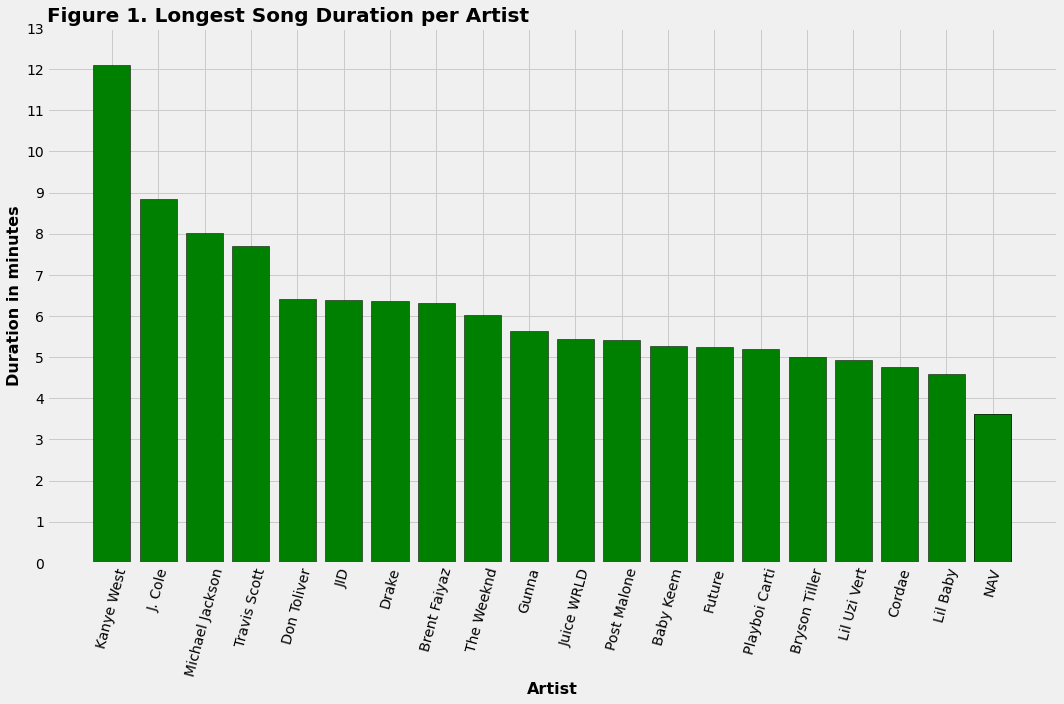

In [23]:
plt.figure(figsize=(15,10))

# want to get the longest songs for each artist
longest_songs = top_10_songs_df[top_10_songs_df['song_duration_rank_by_artist'] == 1]\
.sort_values(by='duration_ms', ascending=False)

# plot a bar chart of artist with longest songs
plt.bar(longest_songs['artist_name'], (longest_songs['duration_ms'] / 1000)/60, color='green', edgecolor='black')

# set title and labels
plt.title('Figure 1. Longest Song Duration per Artist', fontsize=20, fontweight='bold', loc='left')
plt.ylabel('Duration in minutes', fontsize=16, fontweight='bold')
plt.xlabel('Artist', fontsize=16, fontweight='bold')

# adjust x and y ticks
plt.xticks(rotation=75, fontsize=14)
y = np.arange(0, 14, 1)
plt.yticks(y)

plt.tight_layout()

# save figure as png file
plt.savefig('../../assets/longest_songs.png')

### Interesting to see from our bar chart above that most of the longest songs per artist are between 4-7 minutes long, with Kanye West's longest song over 12 minutes in length! Out of all our Artist NAV has the shortest longest song being under 3 minutes.

## Correlation between energy and danceability of songs:

In [24]:
track_feat_df = Q('''
SELECT *
FROM Track_Feature
''')

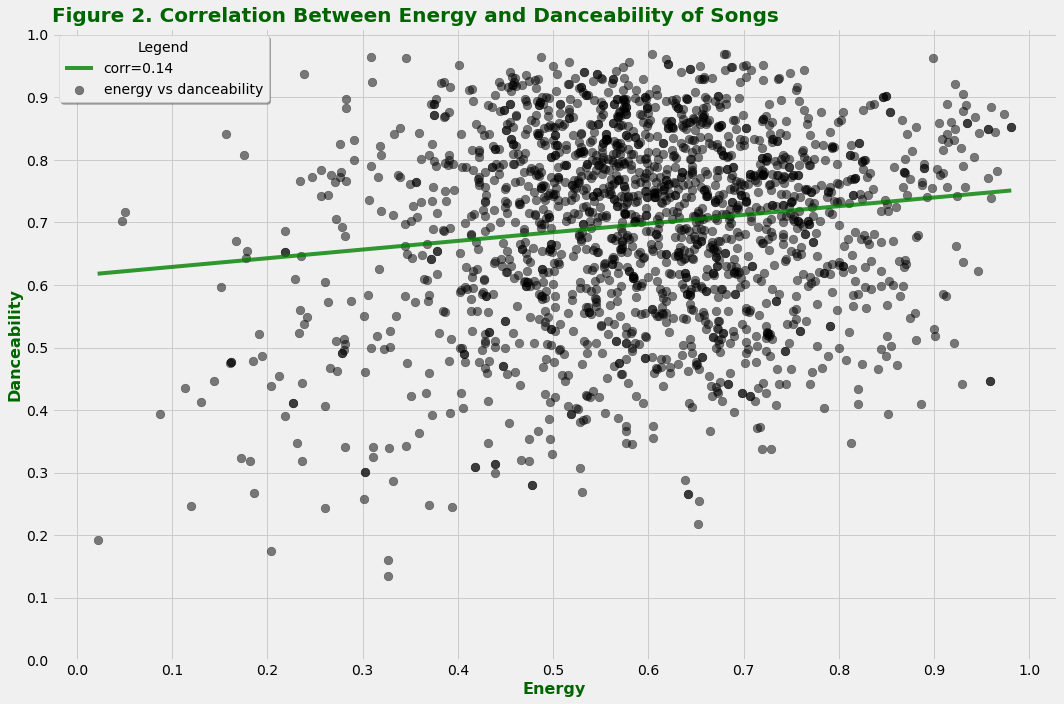

In [25]:
plt.figure(figsize=(15,10))

# get the correlation coefficient between 2 variables
corr_coeff = np.corrcoef(track_feat_df['energy'],track_feat_df['danceability'])[0][1]

# plot the scatter plot of energy vs danceability
plt.scatter(track_feat_df['energy'], track_feat_df['danceability'], 
            color='black', s=75, alpha=0.5, label='energy vs danceability')

# plot the correlation line
plt.plot(np.unique(track_feat_df.energy), 
         np.poly1d(np.polyfit(track_feat_df.energy, track_feat_df.danceability, 1))
         (np.unique(track_feat_df.energy)), 
         color='green', label=f'corr={round(corr_coeff, 2)}', alpha=0.8)

plt.legend(title='Legend', shadow=True)

# set title and labels
plt.title('Figure 2. Correlation Between Energy and Danceability of Songs', 
          fontsize=20, color='darkgreen', fontweight='bold', loc='left')
plt.ylabel('Danceability', fontsize=16, color='darkgreen', fontweight='bold')
plt.xlabel('Energy', fontsize=16, color='darkgreen', fontweight='bold')

# adjust x and y ticks
x = np.arange(0, 1.1, 0.1)
plt.xticks(x)
y = np.arange(0, 1.1, 0.1)
plt.yticks(y)

plt.tight_layout()

# save figure as png file
plt.savefig('../../assets/energy_vs_danceability.png');

### From the scatter plot and the correlation coefficient above we can see that there is not a strong correlation between energy and danceability. We can also see that we have a big cluster of data points for energy between 0.5 and 0.8 and danceability between 0.5 and 0.9.

## Frequency of danceability:

In [26]:
danceability = Q('''
SELECT *
FROM Track_Feature
''')

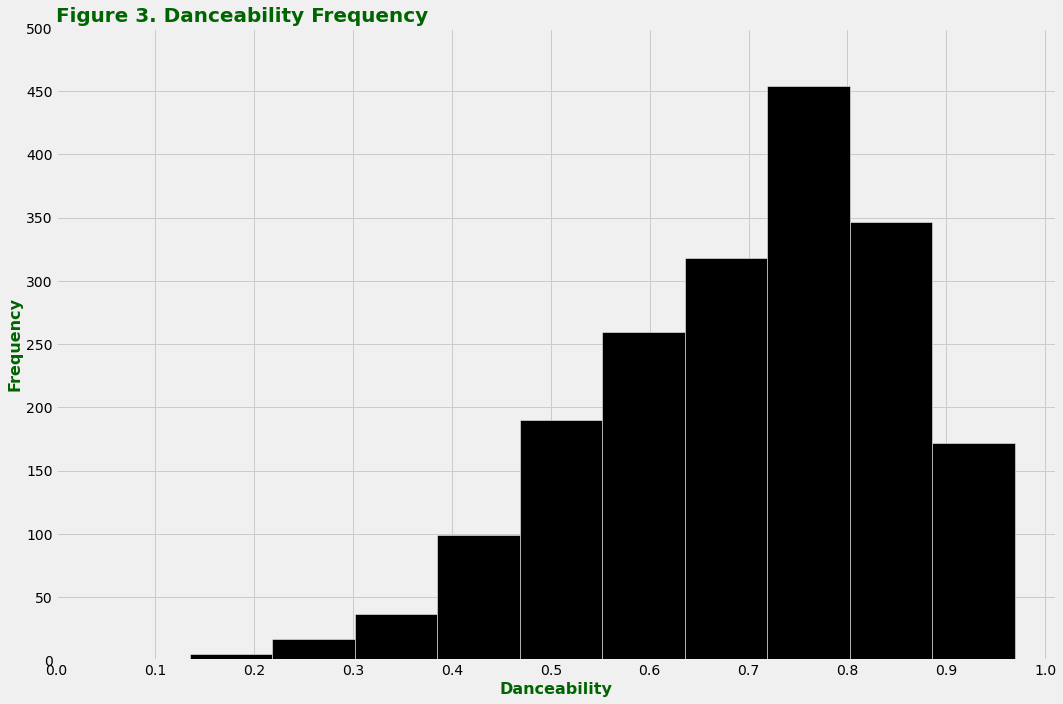

In [27]:
plt.figure(figsize=(15,10))
plt.hist(danceability['danceability'], color='black', edgecolor='white')

# set title and labels
plt.title('Figure 3. Danceability Frequency', 
          fontsize=20, color='darkgreen', fontweight='bold', loc='left')
plt.ylabel('Frequency', fontsize=16, color='darkgreen', fontweight='bold')
plt.xlabel('Danceability', fontsize=16, color='darkgreen', fontweight='bold')

# adjust x and y ticks
x = np.arange(0, 1.1, 0.1)
plt.xticks(x)
y = np.arange(0, 550, 50)
plt.yticks(y)

plt.tight_layout()

# save figure as png file
plt.savefig('../../assets/danceability_frequency.png');

### We can see from the histogram above that most songs have a tempo between 0.7 and 0.8. We can also see that are data tends to be left skewed.

## Count of genre above/below median tempo:

In [28]:
track_feat_df = Q('''
SELECT *
FROM Track_Feature
''')

tempo_med = track_feat_df['tempo'].describe()['50%']

In [29]:
tempo_med

125.049

### The median tempo of all songs is 125 BPM.

In [30]:
tempo_count_genre_df = Q(f'''
SELECT ar.genre, tf.tempo, 
    CASE WHEN tf.tempo >= {tempo_med} THEN 1
    ELSE 0 END AS song_above_below_med
FROM Artist ar
-- join necessary tables together
LEFT JOIN Album a 
    ON a.artist_id = ar.artist_id
LEFT JOIN Track t 
    ON a.album_id = t.album_id
LEFT JOIN Track_Feature tf
    ON t.track_id = tf.track_id
''')

In [31]:
tempo_count_genre_df.head()

,genre,tempo,song_above_below_med
0,canadian hip hop,127.094,1
1,canadian hip hop,154.983,1
2,canadian hip hop,170.538,1
3,canadian hip hop,91.991,0
4,canadian hip hop,83.800,0


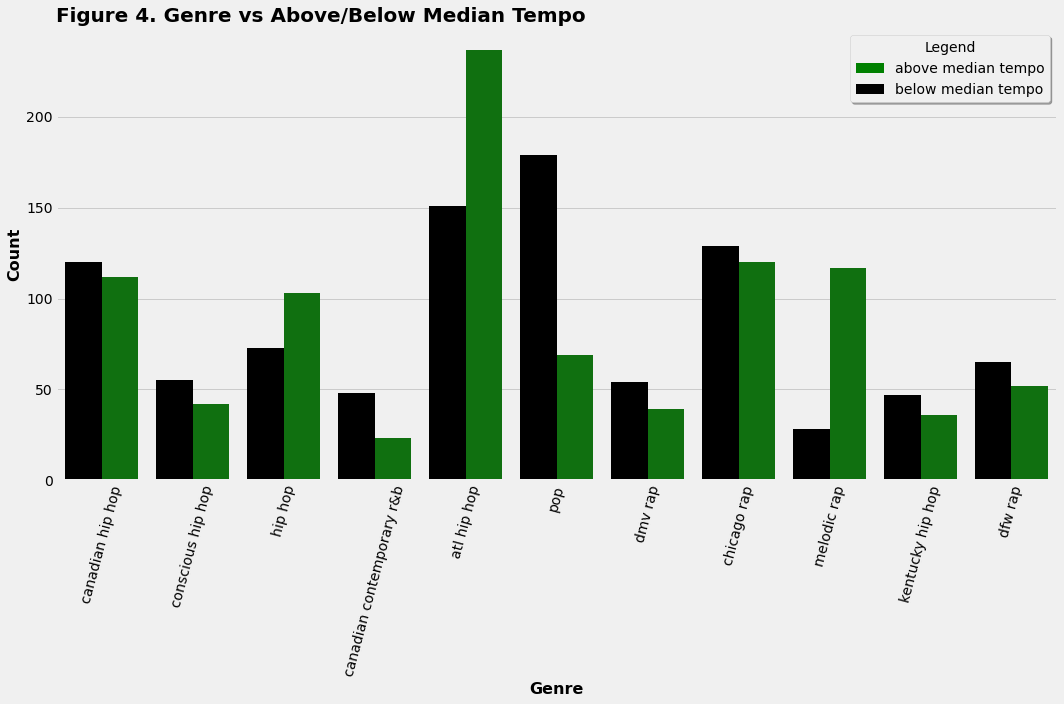

In [32]:
plt.figure(figsize=(15,10))

# plot grouped bar chart
sns.countplot(x='genre', hue='song_above_below_med', data=tempo_count_genre_df, palette={1:'green', 0:'black'});

# set title and labels
plt.title('Figure 4. Genre vs Above/Below Median Tempo', fontsize=20, fontweight='bold', loc='left')

plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=16, fontweight='bold')

# set color patches for legend
color_patches = [
    Patch(facecolor="green", label="above median tempo"),
    Patch(facecolor="black", label="below median tempo")
]

plt.legend(handles=color_patches, shadow=True, title='Legend')

# adjust xticks
plt.xticks(rotation=75, fontsize=14)

plt.tight_layout()

# save figure as png file
plt.savefig('../../assets/genre_above_below_med_tempo.png');

### We can see from our plot that alt hip hop has the most songs above the median temp while canadian contemporary r&b has the lowest. Pop has the most below the median tempo while melodic rap has the least.

In [33]:
# commit changes to the database
db_conn.commit()

# close database connection
db_conn.close()